In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import torch
from numpy import random as rand
import torchio as tio
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from typing import Union, Tuple, List
import matplotlib.pyplot as plt
import PIL
import PIL.Image as Image
from sklearn.model_selection import train_test_split

In [2]:
"Need to specify the local path on computer"
dir_path = "../Task3/"

In [3]:
class Set(Dataset):
    def __init__(self, data_path, to_tensor = True):
        self.data_path = data_path
        self.sub_folders = sorted([folder for folder in os.listdir(self.data_path) if os.path.isdir(os.path.join(self.data_path, folder)) and 'sub-1' in folder])
        self.to_tensor = to_tensor 
    def get_folder_content(self, index):
        sub_folder = os.path.join(self.data_path, self.sub_folders[index])
        data = sorted([name for name in os.listdir(sub_folder) if os.path.isfile(os.path.join(sub_folder,name)) and 'masked' in name])
        seg = sorted([name for name in os.listdir(sub_folder) if os.path.isfile(os.path.join(sub_folder,name)) and 'Lacunes' in name])
        return data, seg
    def __getitem__(self, index):
        path = os.path.join(self.data_path, self.sub_folders[index])
        print(path)
        data, seg = self.get_folder_content(index)
        sample = {}
        img_data = []
        img_seg = []
        for elm in data:
            npy_data = nib.load(os.path.join(path,elm))
            tmp = npy_data.get_fdata()
            img_data.append(tmp)
        for elm in seg:
            npy_data = nib.load(os.path.join(path,elm))
            tmp = npy_data.get_fdata()
            img_seg.append(np.array(tmp))
        sample['data'] = torch.from_numpy(np.array(img_data))
        sample['seg'] = torch.from_numpy(np.array(img_seg))
        
        return sample
    def __len__(self):
        return len(self.sub_folders)

    def crop(self, img):
        if (img.shape == (180,256,256)):
            print('shaping')
            return img.reshape(512,512,192)
        else: print('SHAP', np.array(img.shape))

    
    
   
        

In [29]:
def extract_brain_region(image, brain_mask, background=0.):
	''' find the boundary of the brain region, return the resized brain image and the index of the boundaries'''    
	brain = np.where(brain_mask != background)
	print(brain[0])
	min_z = int(np.min(brain[0]))
	max_z = int(np.max(brain[0]))+1
	min_y = int(np.min(brain[1]))
	max_y = int(np.max(brain[1]))+1
	min_x = int(np.min(brain[2]))
	max_x = int(np.max(brain[2]))+1
	# resize image
	resizer = (slice(min_z, max_z), slice(min_y, max_y), slice(min_x, max_x))
	return image[resizer], [[min_z, max_z], [min_y, max_y], [min_x, max_x]]

In [4]:
X_train, X_test = train_test_split(Set(dir_path), test_size=0.3, random_state=25)

../Task3/sub-102
../Task3/sub-104
../Task3/sub-103
../Task3/sub-105
../Task3/sub-106
../Task3/sub-101


In [36]:
test = X_train[0]['data']
print(test.shape)
out = []
for elm in test:
    print(elm[0][0][0])
    out.append(extract_brain_region(test, test))
for elm in out:
    print('Tyoe elm 0':, type(elm[0]))
    print(len(elm[0]))
    print(type(elm[1]))
    print(len(elm[1]))  


torch.Size([3, 180, 256, 256])
tensor(0., dtype=torch.float64)
[0 0 0 ... 2 2 2]
tensor(0., dtype=torch.float64)
[0 0 0 ... 2 2 2]
tensor(0., dtype=torch.float64)
[0 0 0 ... 2 2 2]
<class 'torch.Tensor'>
3
<class 'list'>
3
<class 'torch.Tensor'>
3
<class 'list'>
3
<class 'torch.Tensor'>
3
<class 'list'>
3


In [6]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")
def slicing(img):
    slice_0 = img[100, :, :]
    slice_1 = img[:, 150, :]
    slice_2 = img[:, :, 80]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle("Center slices for EPI image") 
    plt.show()

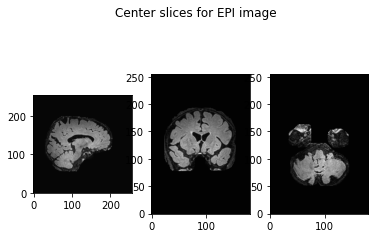

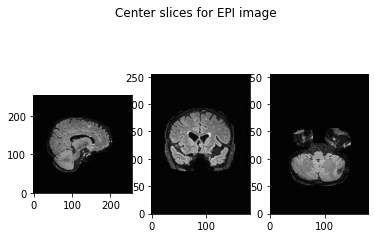

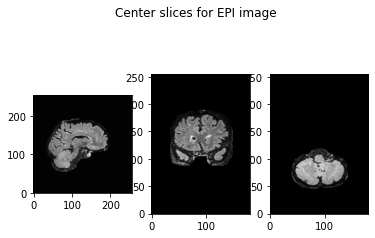

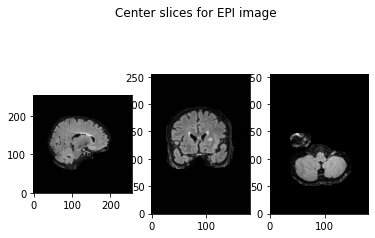

In [7]:
for i in range(len(X_train)):
    img = X_train[i]['data'][0]
    img = img.float()
    slicing(img)

In [8]:
train_set, test_set = DataLoader(X_train, batch_size=1), DataLoader(X_test, batch_size=1)

In [9]:
"Simple neural network with one convolution and activation"
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = self._conv_layer_set(3, 32)
        self.conv2 = self._conv_layer_set(32,64)
        self.finconv = self._conv_layer_set(64,1)
        
    def _conv_layer_set(self, in_c, out_c):
            conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, 1),
            nn.LeakyReLU(),
            )
            return conv_layer

    def forward(self, x):
        x = x.float()
        print('1st convolution')
        out = self.conv1(x)
        print(out.shape)
        out = self.conv2(out)
        out = self.finconv(out)
        return out

In [10]:
tmp = next(iter(train_set))
image = tmp['data']
print(image.shape)
print(type(image))

torch.Size([1, 3, 180, 256, 256])
<class 'torch.Tensor'>


In [11]:

model = CNN()
out_img = model(image)
print(out_img.shape)

1st convolution
torch.Size([1, 32, 180, 256, 256])
torch.Size([1, 1, 180, 256, 256])


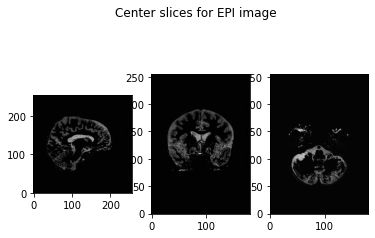

In [15]:
img_arr = out_img.detach().numpy()
slicing(img_arr[0][0])